# Example : Translation
https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

In this example, we apply LSTM for Translation. In particular, translation from english to italian.

Translation is a particular case of sequence-to-sequence processing, i.e. Seq2Seq : transforming a sequence into another sequence. Like transforming sound into text, or many other tasks. The ideas and the structure of the NN what we will see are in general good for Seq2Seq learning.

We will perform this translation character-by-character. Character-based translation. Of course, this is not particularly good: a word-level tokenization would be better.

## DATASET
We will use a dataset contained here http://www.manythings.org/anki/

### Download

In [1]:
# Download and unzip the data
!curl -O http://www.manythings.org/anki/ita-eng.zip
!unzip ita-eng.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7600k  100 7600k    0     0  10.1M      0 --:--:-- --:--:-- --:--:-- 10.1M
Archive:  ita-eng.zip
  inflating: ita.txt                 
  inflating: _about.txt              


We have downloaded a file "ita.txt". It is a txt file, in which each line is a pair english sentence - italian sentence. The two sentences are separated by a TAB (i.e. '\t').

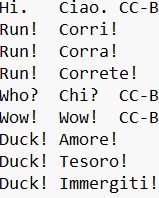

### Loading

We create two lists.
- `english_texts`: list of english sentences
- `italian_texts`: list of italian sentences

The dataset is huge: we take only the first $10000$ pairs of sentences english-italian.

Important point: in each italian sentence, we need to add a special character START at the beginning, and a special character END at the end. We do this because we will use START as character for starting the generation of an italian sentence, and END as character for stopping the generation. In our specific case, we use START='\t' and END='\n'. We need to add these two characters

In [2]:
path = 'ita.txt'

n_samples = 10000

In [3]:
# Reading all the lines
with open(path, "r", encoding="utf-8") as f:
    # List of lines in the file
    lines = f.read().split("\n")

In [4]:
# Initializing the lists
english_texts = []
italian_texts = []

# We iterate over all the lines
for line in lines[: n_samples]:
    # Extract the english and italian sentences
    english_text, italian_text, _ = line.split("\t")

    # Inject the START and STOP characters into the italian sentence
    italian_text = "\t" + italian_text + "\n"

    english_texts.append(english_text)
    italian_texts.append(italian_text)

## PREPROCESSING
Several operations we must perform before training our model.

### Computing the set of all possible english characters and the set of all possible italian characters

Computing the set of all possible english characters. $n$ is the number of all possible english characters.

In [5]:
english_characters = set()

for english_text in english_texts:
  english_characters.update(set(english_text))

english_characters = sorted(list(english_characters))

In [6]:
n = len(english_characters)
n

66

Computing the set of all possible italian characters. $m$ is the number of all possible italian characters.

In [7]:
italian_characters = set()

for italian_text in italian_texts:
  italian_characters.update(set(italian_text))

italian_characters = sorted(list(italian_characters))

In [8]:
m = len(italian_characters)
m

75

### Mapping characters into numbers
We map characters into numbers. We create a biunivocal correspondance between characters and numbers.

This both for the english and the italian characters.

Mapping the english characters

In [9]:
# Dictionary, which maps english characters into the corresponding integers (i.e. indeces) 
english_char2index = dict((c, i) for i, c in enumerate(english_characters))

# Dictionary, which maps integers/indeces into the corresponding english characters 
english_index2char = dict((i, c) for i, c in enumerate(english_characters))

Mapping the italian characters

In [10]:
# Dictionary, which maps italian characters into the corresponding integers (i.e. indeces) 
italian_char2index = dict((c, i) for i, c in enumerate(italian_characters))

# Dictionary, which maps integers/indeces into the corresponding italian characters 
italian_index2char = dict((i, c) for i, c in enumerate(italian_characters))

### Computing the max length of an english sentence and the max length of an italian sentence

We call $N$ the max length of an english sentence, $M$ the max length of an italian sentence.

In [11]:
N = max([len(txt) for txt in english_texts])
M = max([len(txt) for txt in italian_texts])

In [12]:
print('Max length of an english sentence', N)
print('Max length of an italian sentence', M)

Max length of an english sentence 13
Max length of an italian sentence 46


Why are we interested in these quantities? Because we want to make all the english sentences to have the same length: they will have have the same length $N$. If an english sentence has less than $N$ characters, we fill the remaning space with the blank " " character. The same for the italian sentences: they all will have the same length $M$.

### One-hot encoding the english characters
Let's one hot encode the english characters.

We want to represent an english character as a vector, with length `n`: there is a value for each possible english character in our text. So, given an english character $c$, with corresponding integer $j$, we represent it as a vector of length `n`. In each index $i$ we place: $0$ if that index/character $i$ is not $c$; $1$ if that index/character $i$ is $c$. basically, we put a $0$ if $i \neq j$, $1$ otherwise.

To sum up, we represent each english character $c$ with a vector with only $0$ except in the position corresponding to that character, where there is a $1$. This is called one-hot encoding.

So, we build our tensor `english_data`, which will contain the english sentences $x$. Each english sentence $x$ is a sequence of $N$ characters, where each character is represented as a vector of `n` values. The dimensions of `english_data` are $n_{samples}*N*n$, since there are $n_{samples}$ english sentences $x$, each of them is a sequence of $N$ characters, and each characters is a vector of $n$ values. 


The values in the tensor `english_data` are simply $0/1$. 

In [13]:
import numpy as np

In [14]:
# Initializing 'english_data', to all 0
english_data = np.zeros((n_samples, N, n), dtype=np.float32)

In [15]:
# Populating 'english_data'

# We iterate over all english sentences x: each x is a sequence of at most N characters
for i, x in enumerate(english_texts):

  # We iterate over all characters in x
  for j, ch in enumerate(x):
    # We place 1 in the position corresponding to that character
    english_data[i, j, english_char2index[ch]] = 1.0

  j +=1

  # If the length of the current english sentence x is less than N, we fill the remaning space with all space characters " "
  while j<N:
    english_data[i, j, english_char2index[" "]] = 1.0
    j += 1

The shape is $n_{samples}*N*n$, where $n_{samples}=10000$ and $N=13$ and $n=66$.

In [16]:
english_data.shape

(10000, 13, 66)

Let's inspect an english sentence $x$

In [17]:
# English sentence x: it is a sequence of N=13 characters, where each character is a vector of n=66 values
x = english_data[0]
print(x.shape)

(13, 66)


Let's inspect a character $c$ in $x$

In [18]:
# Character c: it is a boolean vector of n=66 values
c = x[0]
print(c.shape)
print(c)

(66,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### One-hot encoding the italian characters
We do the same thing for the italian characters.

We want to represent an italian character as a boolean vector, with length `m`: all $0$ except in the position corresponding to that character, where there is a $1$. 

So, we build our tensor `italian_data`, which will contain the italian sentences $x^{'}$. Each italian sentence $x^{'}$ is a sequence of $M$ characters, where each character is represented as a vector of `m` values. The dimensions of `italian_data` are $n_{samples}*M*m$, since there are $n_{samples}$ italian sentences $x^{'}$, each of them is a sequence of $M$ characters, and each characters is a vector of $m$ values. 


The values in the tensor `italian_data` are simply $0/1$. 

In [19]:
# Initializing 'italian_data', to all 0
italian_data = np.zeros((n_samples, M, m), dtype=np.float32)

In [20]:
# Populating 'italian_data'

# We iterate over all italian sentences x': each x' is a sequence of at most N characters
for i, x1 in enumerate(italian_texts):

  # We iterate over all characters in x'
  for j, ch in enumerate(x1):
    # We place 1 in the position corresponding to that character
    italian_data[i, j, italian_char2index[ch]] = 1.0

  j +=1 

  # If the length of the current italian sentence x' is less than M, we fill the remaning space with all space characters " "
  while j<M:
    italian_data[i, j, italian_char2index[" "]] = 1.0
    j += 1

The shape is $n_{samples}*M*m$, where $n_{samples}=10000$ and $M=46$ and $n=75$.

In [21]:
italian_data.shape

(10000, 46, 75)

Let's inspect an italian sentence $x^{'}$

In [22]:
# Italian sentence x': it is a sequence of M=46 characters, where each character is a vector of n=75 values
x1 = italian_data[0]
print(x1.shape)

(46, 75)


Let's inspect a character $c$ in $x$

In [23]:
# Character c: it is a boolean vector of n=75 values
c = x1[0]
print(c.shape)
print(c)

(75,)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


### Defining utilities functions
For one-hot encoding and undo the one-hot encoding. 

In [24]:
def oneHotEncode_english(english_sentence):
  l = len(english_sentence)

  if l>N:
    raise Exception('l>N')

  x = np.zeros((1, N, n))
  for i,c in enumerate(english_sentence):
    x[0, i, english_char2index[c]] = 1.0

  i +=1

  while i<N:
     x[0, i, english_char2index[' ']] = 1.0 
     i += 1

  return x

In [25]:
def undo_oneHotEncode_english(x):
  l = x.shape[1]
  english_sentence = ''

  for i in range(l):
    char_index = np.argmax(x[0, i, :])
    char = english_index2char[char_index]
    english_sentence += char

  return english_sentence

In [26]:
def oneHotEncode_italian(italian_sentence):
  l = len(italian_sentence)

  if l>M:
    raise Exception('l>M')

  x = np.zeros((1, M, m))
  for i,c in enumerate(italian_sentence):
    x[0, i, italian_char2index[c]] = 1.0

  i += 1

  while i<M:
     x[0, i, italian_char2index[' ']] = 1.0 
     i += 1

  return x

In [27]:
def undo_oneHotEncode_italian(x):
  l = x.shape[1]
  italian_sentence = ''

  for i in range(l):
    char_index = np.argmax(x[0, i, :])
    char = italian_index2char[char_index]
    italian_sentence += char

  return italian_sentence

In [28]:
undo_oneHotEncode_english(oneHotEncode_english('Hello'))

'Hello        '

In [29]:
undo_oneHotEncode_english(english_data[0:1,:,:])

'Hi.          '

In [30]:
undo_oneHotEncode_italian(italian_data[0:1,:,:])

'\tCiao!\n                                       '

## NEURAL NETWORK: DESCRIPTION
Let's describe our NN for Seq2Seq processing. We have two LSTM: one is the **encoder** and one is the **decoder**.

### Idea
We want to translate character by character. But if we do this simply in sequence, without having global information on the english sentence, this has no sense. We want to translate character by character, but while having a global information (i.e. context) about the whole english sentence to translate.

For doing so, we want to encode the english sentence into a global information. Encoding representing the global information/context of the english sentence. Latent encoding.

This is typically done in DL: for capturing the global information, we encode.

### LSTM encoder
Input: english sentence $x$, which is a sequence of $N$ characters $X_1, ..., X_N$. Each $X_t$ is a vector with $n$ values.

Output: sequence $h_1, ..., h_N$.

Memory states: sequence $C_1, ..., C_N$.

Each pair $(h_t,C_t)$ represents the encoding of the sub-sequence up to $t$, i.e. $X_1, ..., X_t$.

We are interested only in the encoding of the whole english sequence $X_1, ..., X_N$: the latent encoding is $(h_N,C_N)$. We take only the last encoding.

We throw away all the other outputs and all the other memory states. 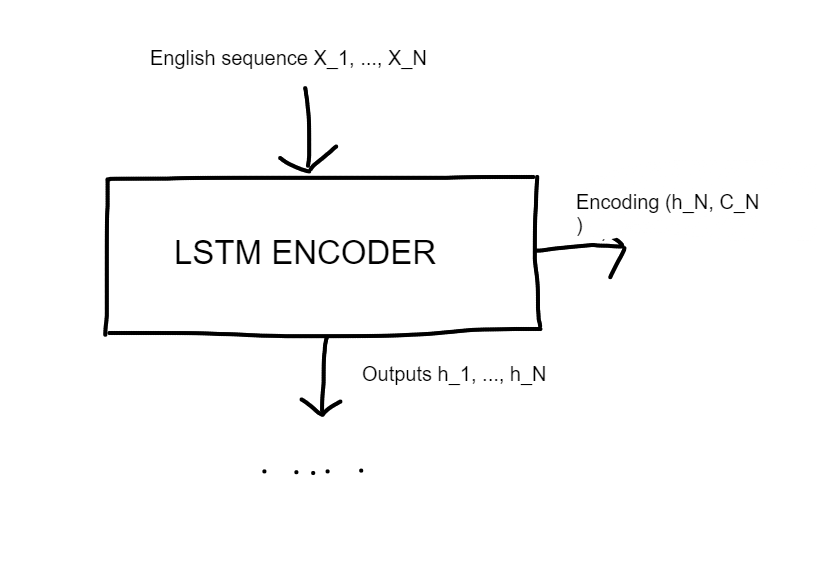

We use $256$ as dimension for each output $h_t$, which is also the dimension of each memory state $C_t$. Each $h_t$ and each $C_t$ is a vector with $256$ values. 

Therefore, the latent encoding consists in a couple $(h_N,C_N)$ of two vectors with $256$ values each.

In [31]:
latent_dim = 256

### LSTM decoder: auto-regressive generation
The aim of the decoder is to generate the translated italian sequence, character by character.

This generation is done in a peculiar way. 
- The decoder takes in input the italian sequence generated so far by the decoder itself. 
- The decoder generates in output the next character to append to the italian sequence generated so far.

Example. We are generating an italian sentence.
1. At the beginning, the input of the LSTM decoder is just the START character (i.e. '\t'). The decoder generates the next character of the italian sentence: 'C'. The italian sentence is now "START C".
2. Then, the input of the decoder is the sequence "START C". The decoder generates the next character of the italian sentence: 'i'. The italian sentence is now "START C i".
3. Then, the input of the decoder is the sequence "START C i". The decoder generates the next character of the italian sentence: 'a'. The italian sentence is now "START C i a".
4. Then, the input of the decoder is the sequence "START C i a". The decoder generates the next character of the italian sentence: 'o'. The italian sentence is now "START C i a o".
5. Then, the input of the decoder is the sequence "START C i a o". The decoder generates the next character of the italian sentence: 'STOP' (i.e. '\n'). The italian sentence is now "START C i a o STOP".
6. End of the generation: the generated italian sequence is "Ciao".

This kind of generation is called **autoregressive generation**: at each step, the decoder takes in input what has been generated so far, and it generates the next character.

Now we can also better understand the aim of the START and STOP characters in the italian sentences: their aim is to, respectively, initiate the generation of the decoder and end the generation of the decoder.

### LSTM decoder
Input: italian sentence  generated so far, i.e. $x^{'}$ , which is a sequence of $T$ characters  $X^{'}_1,...,X^{'}_T$ . Each charcter $X^{'}_t$  is a vector with $m$ values. $T$ is the length of the sentence generated so far (it is variable).

Output: sequence $h^{'}_1,...,h^{'}_T$.

Memory states: sequence $C^{'}_1,...,C^{'}_T$.

Each output $h^{'}_t$, with $t \leq T$, represents the prediction of the next italian character in the sequence, which is the  $(t+1)$-th character: character $X^{'}_{t+1}$ . The output $h^{'}_t$ represents the prediction made by the RNN given the italian sub-sequence $X^{'}_1,...,X^{'}_t$ : so, $h^{'}_t$  is the predicted next character $X^{'}_{t+1}$ in the sequence (prediction of the $(t+1)$-th character).

More precisely, each output $h^{'}_t$ is a vector of $m$ values, representing a probability distribution over all possible italian characters: it's the categorical distribution for predicting the next italian character $X^{'}_{t+1}$ in the sequence, given all the previous italian sequence $X^{'}_1,...,X^{'}_t$. 

We are interested only in predicting the next italian character after the whole given italian sentence $X^{'}_1,...,X^{'}_T$: we are interested only in predicting $X^{'}_{T+1}$. Therefore, we take only the last output $h^{'}_T$.

We throw away all the other outputs.

### Precisation about the output of the decoder
Actually, it is not true that each output $h^{'}_t$ represents the probability distribution for the next italian character $X^{'}_{t+1}$. $h^{'}_t$ is not a probability distribution.

Actually, $h^{'}_t$ is a vector of `latent_dim` values (i.e. $256$). The purpose of this vector is to be used by a Dense layer for building the probability distribution for the next italian character $X^{'}_{t+1}$: we call this probability distribution $Y_{t}$.

So:
- Each output element $h^{'}_t$ is not a vector of length $m$, but a vector of `latent_dim` values. (So, also each memory state $C_t$ is a vector of `latent_dim` values). Instead, the final prediction $Y_t$ is a vector of length $m$.
- Each output element $h^{'}_t$ is not directly our probability distribution for the next italian character $X^{'}_{t+1}$, but it is used by a Dense layer for making that probability distribution $Y_t$. From an high level point of view, we can consider $h^{'}_t$ as the probability distribution for the next italian character $X^{'}_{t+1}$.

This means that, given a italian sequence $X^{'}_1,...,X^{'}_T$, we consider only the last output $h^{'}_T$ of the RNN, which is a vector with `latent_dim` values. We pass that to a Dense layer for making the probability distribution for the next character italian $X^{'}_{T+1}$: this probability distribution is $Y_T$, a vector of $m$ values.

### LSTM decoder: usage of the encoding $(h_N,C_N)$
However, the current decoder does not use in any way the encoding $(h_N,C_N)$ of the english sentence, produced by the encoder. How can we plug the encoding $(h_N,C_N)$ into our LSTM decoder?

We use $C_N$ as starting memory state of our LSTM decoder, which is $C^{'}_0$. And we use $h_N$ as starting output value of our LSTM decoder, which is $h^{'}_0$.

Basically, $C_N$ and $h_N$ are used in the first LSTM module as, respectively, the current memory state (i.e. $C^{'}_0$) and the previous output (i.e. $h^{'}_0$). 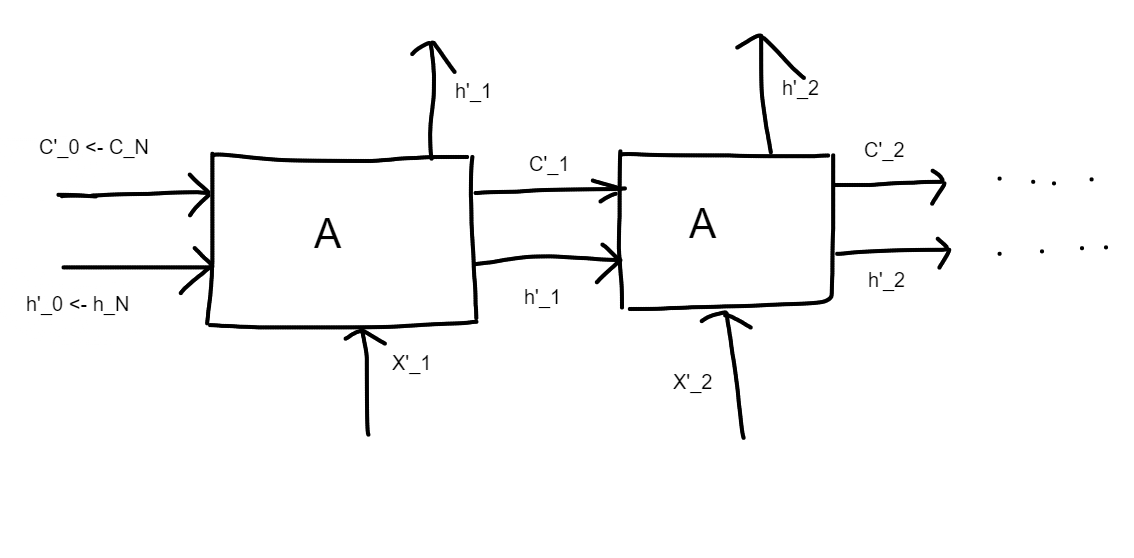

This explains why each output $h^{'}_t$ and each memory state $C^{'}_t$ of the decoder have the same dimensions of the outputs $h_t$ and memory states $C_t$ of the encoder, which is `latent_dim`.

### LSTM decoder: overall picture
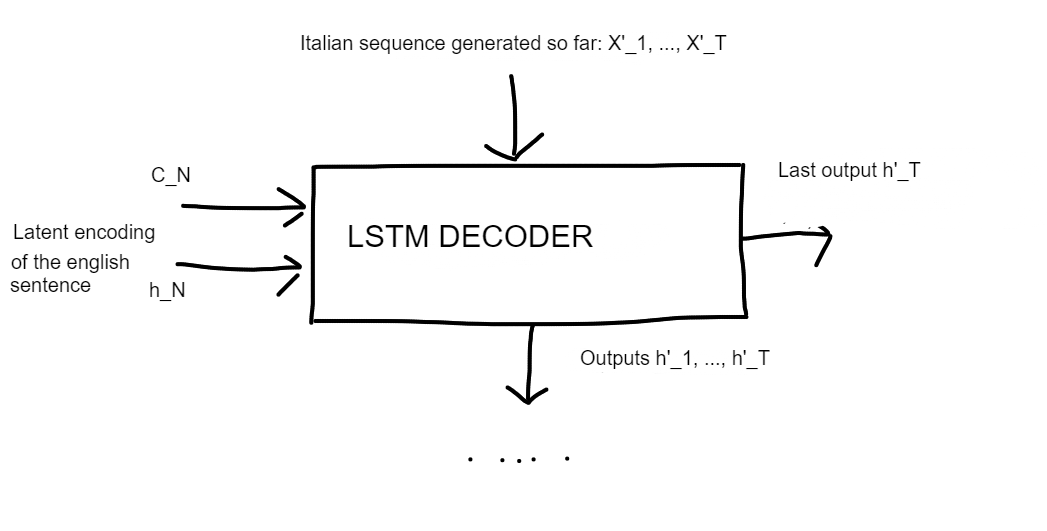
Since now we have said that the encoder takes in input the italian sequence generated so fat, which has length $T$. This $T$ is variable, it is not fixed.

This is not a problem. It is not a problem defining a NN with a variable dimension. Non-fixed input dimension. 

In Keras we leave an input dimension unspecified by simply specifying `None`: the NN is able to work with any value of that dimension.

### Dense layer
The final part of our NN is a Dense layer. It takes in input the last output of the LSTM decoder, i.e. $h^{'}_T$ (which is a vector with `latent_dim` values), and it produces in output $Y_T$, which is a probability distribution over the $m$ possible italian character, for predicting the next italian character $X^{'}_T$.

So, it is a Dense layer with `latent_dim` inputs, with $m$ outputs, and with softmax activation function.

### Our Neural Network: full picture
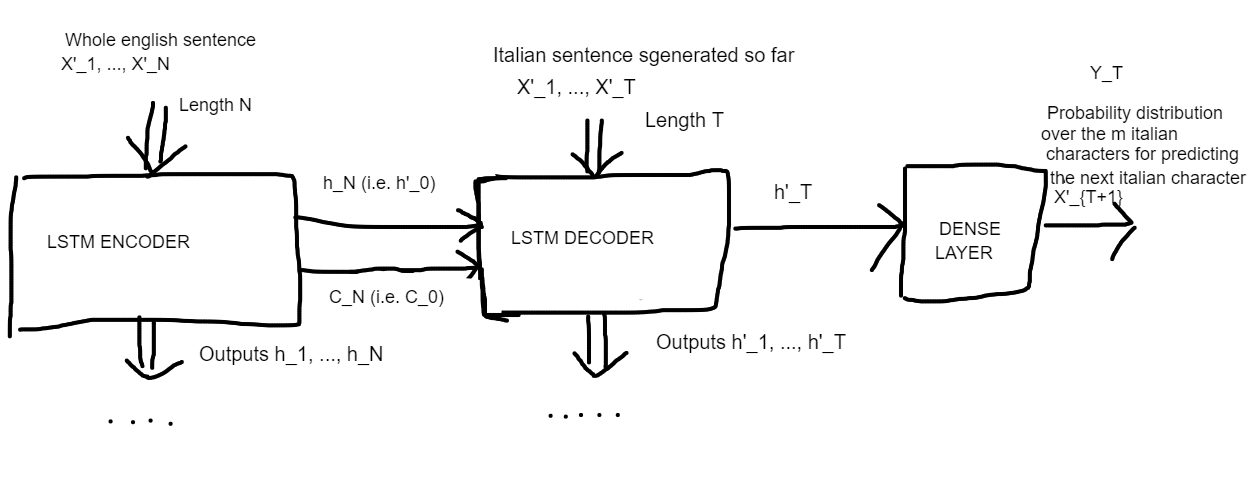

## TRAINING: DESCRIPTION
Let's describe how the training works.

*Note: the notation used in this section is slightly different from the notation used in the previous section.*

### Idea

Our training set consists in $n_{samples}$ pairs of sentences english-italian. 
- Let's denote with $x$ an english sentence, which is a sequence of $N$ characters $X_1,...,X_N$.
- Let's denote with $y$ an italian sentence, which is a sequence of $M$ characters $Y_1, ..., Y_M$.

So, we have a pair of sentences $x$-$y$. We want to train the model on it.
1. First of all, we encode the english sentence using the encoder, into the latent encoding $h_N,C_N$.
2. Then, we take all the possible sub-strings $Y_1,...,Y_T$ of the italian sentence $y$, where $T\leq M$. For each sub-strings $Y_1,...,Y_T$:
  * we give this sequence in input to the decoder;
  * we take the last output $h'_T$;
  * we give that to the Dense layer, producing the categorical distribution $\hat{Y}_{T+1}$, which is the categorical distribution for predicting the next character $Y_{T+1}$ in the italian sentence;
  * We measure the error between the true next character $Y_{T+1}$ in the sequence and our output $\hat{Y}_{T+1}$. This can be measured easily by using the categorical crossentropy, since $Y_{T+1}$ can be seen as the actual cateogorical distribution and $\hat{Y}_{T+1}$ can be seen as the predicted categorical distribution.

Given a pair of sentences $x$-$y$, we do this for all possible sub-strings $Y_1,...,Y_T$ of $y$. Then, we aggregate together all the obtained error values.

This aggregation is also performed through all the pairs $x$-$y$ in our batch. 

### Teacher forcing
It is very important to notice that, for generating the prediction $\hat{Y}_{T+1}$, the actual true italian sentence $Y_1,...,Y_T$ is given in input to the decoder. The ground truth $Y_1,...,Y_T$ is given in input to the LSTM decoder for generating the next prediction $\hat{Y}_{T+1}$.

This way of training our model is called **teacher forcing**.

The alternative way of proceeding would be to give in input to the LSTM decoder the italians sentence $\hat{Y}_1,...,\hat{Y}_T$ generated so far by the decoder for predicting the next character $\hat{Y}_{T+1}$. Basically, the alternative way would be to proceed like we do for generation at test time.

Teacher forcing is in general better for training our model. Because using the ground truth $Y_1,...,Y_T$  for generating the next prediction $\hat{Y}_{T+1}$ is more reliable than using the sentence $\hat{Y}_1,...,\hat{Y}_T$ generated by the decoder itself, since the model it is still learning and it is not good yet.

### Sum up
So, the training process consists in:
- taking a true italian sentence $Y_1,...,Y_M$;
- generate the predicted next characters $\hat{Y}_2,...,\hat{Y}_M$ (starting from the second character);
- compare these characters with the true characters $Y_2,...,Y_M$ (starting from the second character).

Actually, the predicted next characters are $\hat{Y}_2,...,\hat{Y}_{M+1}$, since the inputs are $Y_1,...,Y_M$. Length $M$. Therefore, the true characters for measuring the errors of the predictions are $Y_2,...,Y_{M+1}$, where the last character $Y_{M+1}$ is a fake character added to the end, namely the blank characters ' '.

### Italian ground truth for computing the errors
From the previous point (the sum up) it can be noticed that the true italian sentence $Y_1,...,Y_M$ is used two times.
1. For generating the predictions of the next characters. We don't use the last character: we use the actual italian sentence $Y_1,...,Y_M$.
2. For measuring the errors with the predicted next characters. We don't use the first character (i.e. the START character), and we add a fake character to the end: we use $Y_2,...,Y_{M+1}$. 

So, we need to build another set of italian sentences, which will be only used in the training phase, for computing the errors. `italian_data_output` dataset: true italian sentences for measuring the errors of the next predicted characters. They are the italian sentences withour the first START character. 

Instead, in input to the decoder, we pass the actual true italian sentences in `italian_data`.

Creating `italian_data_output`

In [32]:
# Inizialization of 'italian_data_output'
italian_data_output =  np.zeros((n_samples, M, m))

# Populating 'italian_data_output'

# Iterate over all italian sentences x' in 'italian_data'
for i,x1 in enumerate(italian_data):
  # Remove the first character (START character)
  x1 = np.delete(x1, (0), axis=0)
  
  # Append the blanck character to the end
  new_row = np.zeros((1, m))
  new_row[0, italian_char2index[' ']] = 1.0
  x1 = np.append(x1, new_row, axis=0)

  italian_data_output[i, :, :] = x1

In [33]:
print(italian_data.shape)
print(italian_data_output.shape)

(10000, 46, 75)
(10000, 46, 75)


In [34]:
undo_oneHotEncode_italian(italian_data[0:1,:,:])

'\tCiao!\n                                       '

In [35]:
undo_oneHotEncode_italian(italian_data_output[0:1,:,:])

'Ciao!\n                                        '

### Training: actual implementation
Given a pair $x$-$y$, it would be quite expensive to iterate over all possible sub-strings $Y_1,...,Y_T$ of $y$, and giving that sub-string $Y_1,...,Y_T$ in input to the decoder for generating the prediction $\hat{Y}_{T+1}$. We would have to apply a lot of time the decoder, for a single pair $x$-$y$.

This process is simplified in the following way.

Pair $x$-$y$.
1. We give $x$ in input to the encoder: we take the encoding $h_N,C_N$.
2. We take the full italian sentence $Y_1,...,Y_{M-1}$ (except last character). We give all that in input to the decoder, with also the encoding $h_N,C_N$.
3. From the decoder, we don't take only the last output $h^{'}_{M-1}$, but we take all the outputs $h^{'}_1,...,h^{'}_{M-1}$.
4. We give all these outputs $h^{'}_1,...,h^{'}_{M-1}$ to the Dense layer, producing the predictions for all the next characters in the italian sentence: predictions $\hat{Y}_2,...,\hat{Y}_M$.
5 We compare the predictions $\hat{Y}_2,...,\hat{Y}_M$ with the true italian sentence $Y_2,...,Y_M$.

In this way, we apply the decoder just one time for each pair $x$-$y$. With just one application of the decoder, we compute all the predictions $\hat{Y}_2,...,\hat{Y}_M$. 

This simplifies a lot the training. And also the code.

Insight. Why is this possible? It is possible for a concept that we have explained before, when talking about the decoder in general. Given an italian sequence $Y_1,...,Y_T$, each intermediate output $h^{'}_t$ of the LSTM decoder, with $t \leq T$, has a meaning: $h^{'}_t$ is the vector used for predicting the next character $Y_{t+1}$. Vector used for generating the prediction $\hat{Y}_{t+1}$. Not only the last output has a meaning, but every output of the LSTM decoder has a meaning.

## IMPLEMENTATION
Let's finally see the implementation of all this.

### Model

In [36]:
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras import Model

Encoder

In [37]:
# Input: the input is an english sentence, i.e. sequence of N characters, where each of them is a vector of n values
encoder_inputs = Input(shape=(N,n))

# Encoder: each h_t/C_t has dimension `latent_dim`. We want also to return the last memory state C_N
encoder = LSTM(units=latent_dim, return_state=True)

# Application of the encoder on the ensligh sentence
h_N, h_N, c_N = encoder(encoder_inputs)

# Encoding: h_N, C_N
encoding = [h_N, c_N]

In [38]:
# The first printed dimension is the batch dimension
print('Shape of "encoder_inputs":', encoder_inputs.shape)
print('Shape of "h_N":', h_N.shape)
print('Shape of "C_N":', c_N.shape)

Shape of "encoder_inputs": (None, 13, 66)
Shape of "h_N": (None, 256)
Shape of "C_N": (None, 256)


Decoder

In [39]:
# Input: the input is the italian sentence generated so far, i.e. sequence of T characters, where each of them is a vector of m values
# We leave the number T as variable, unspecified
decoder_inputs = Input(shape=(None,m))

# Decoder: each h'_t/C'_t has dimension `latent_dim`. We want to return all the outputs h'_1,...,h'_T: this is done for the training, as 
# explained above
decoder = LSTM(units=latent_dim, return_sequences=True, return_state=True)

# Application of the decoder on the italian sentence. We give the encoding of the english sentence as initial stat
h_outputs, h_last, c_last = decoder(decoder_inputs, initial_state=encoding)

In [40]:
# The first printed dimension is the batch dimension, the second is the variable length T
print('Shape of "decoder_inputs":', decoder_inputs.shape)
print('Shape of "h_outputs":', h_outputs.shape)
print('Shape of "h_N":', h_N.shape)

Shape of "decoder_inputs": (None, None, 75)
Shape of "h_outputs": (None, None, 256)
Shape of "h_N": (None, 256)


Dense layer

In [41]:
# Dense layer: it has m outputs, and softmax activation function
dense = Dense(units=m, activation='softmax')

# Application of the dense layer on all the outputs of the decoder: this generated a cat distribution y_hat for each italian character.
# This is done for training, as explained above.
cat_distributions = dense(h_outputs)

In [42]:
# The first printed dimension is the batch dimension, the second is the variable length T
print('Shape of "cat_distributions":', cat_distributions.shape)

Shape of "cat_distributions": (None, None, 75)


Model

In [43]:
# It is important to notice that the model has two inputs: encoder_inputs (i.e. the english sentences); decoder_inputs (i.e. the italian
# sentences).
# It has a single output, which are the categorical distributions
model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=cat_distributions)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 13, 66)]     0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, None, 75)]   0           []                               
                                                                                                  
 lstm_8 (LSTM)                  [(None, 256),        330752      ['input_9[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

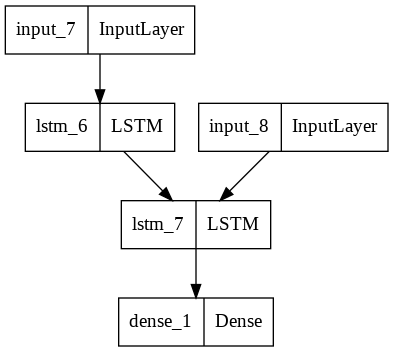

In [ ]:
import tensorflow.keras as ks
ks.utils.plot_model(model)

### Compiling

In [44]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Training

In [46]:
batch_size = 64
epochs = 100

# Input of the encoder: the english sentences
# Input of the decoder: the italian sentences, without the last STOP character
# Target of the model: the italian sentences, without the first START character
hist = model.fit([english_data, italian_data], italian_data_output, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/100
141/141 [==============================] - 9s 17ms/step - loss: 1.1688 - accuracy: 0.7093 - val_loss: 1.0228 - val_accuracy: 0.7169
Epoch 2/100
141/141 [==============================] - 2s 12ms/step - loss: 0.8112 - accuracy: 0.7698 - val_loss: 0.8284 - val_accuracy: 0.7515
Epoch 3/100
141/141 [==============================] - 2s 12ms/step - loss: 0.6767 - accuracy: 0.7989 - val_loss: 0.7494 - val_accuracy: 0.7727
Epoch 4/100
141/141 [==============================] - 2s 12ms/step - loss: 0.6064 - accuracy: 0.8151 - val_loss: 0.7075 - val_accuracy: 0.7821
Epoch 5/100
141/141 [==============================] - 2s 12ms/step - loss: 0.5576 - accuracy: 0.8272 - val_loss: 0.6707 - val_accuracy: 0.7923
Epoch 6/100
141/141 [==============================] - 2s 12ms/step - loss: 0.5194 - accuracy: 0.8378 - val_loss: 0.6514 - val_accuracy: 0.7971
Epoch 7/100
141/141 [==============================] - 2s 12ms/step - loss: 0.4855 - accuracy: 0.8478 - val_loss: 0.6261 - val_accuracy:

In [ ]:
batch_size = 64
epochs = 100

# Input of the encoder: the english sentences
# Input of the decoder: the italian sentences, without the last STOP character
# Target of the model: the italian sentences, without the first START character
hist = model.fit([english_data, italian_data], italian_data_output, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/100
141/141 [==============================] - 44s 287ms/step - loss: 1.1758 - accuracy: 0.7071 - val_loss: 1.0520 - val_accuracy: 0.7162
Epoch 2/100
141/141 [==============================] - 40s 282ms/step - loss: 0.8243 - accuracy: 0.7675 - val_loss: 0.8583 - val_accuracy: 0.7503
Epoch 3/100
141/141 [==============================] - 39s 275ms/step - loss: 0.6737 - accuracy: 0.7985 - val_loss: 0.7651 - val_accuracy: 0.7674
Epoch 4/100
141/141 [==============================] - 39s 279ms/step - loss: 0.6038 - accuracy: 0.8156 - val_loss: 0.6981 - val_accuracy: 0.7861
Epoch 5/100
141/141 [==============================] - 40s 285ms/step - loss: 0.5577 - accuracy: 0.8276 - val_loss: 0.6737 - val_accuracy: 0.7919
Epoch 6/100
141/141 [==============================] - 40s 282ms/step - loss: 0.5207 - accuracy: 0.8376 - val_loss: 0.6403 - val_accuracy: 0.8042
Epoch 7/100
141/141 [==============================] - 40s 282ms/step - loss: 0.4883 - accuracy: 0.8473 - val_loss: 0.6375 -

In [ ]:
model.save_weights('translator.h5')

### Analysis of the results

In [ ]:
import matplotlib.pyplot as plt
def plot_history(training_history, n_epochs):
    epochs = range(1,n_epochs+1)

    plt.plot(epochs, training_history.history['loss'], label='train_loss')
    plt.plot(epochs, training_history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.title('Loss')

    plt.figure()
    plt.plot(epochs, training_history.history['accuracy'], label='train_accuracy')
    plt.plot(epochs, training_history.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.title('Accuracy')

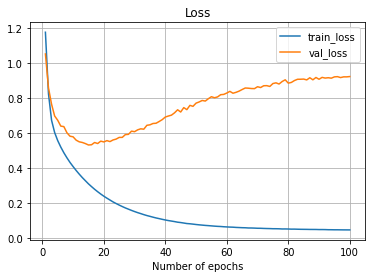

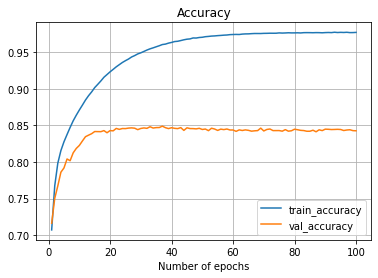

In [ ]:
plot_history(hist, 100)

**Pretty bad results!!! Pretty sever overfitting!!!**

## PERFORM TRANSLATION
Let's now perform some translation. Namely, let's see how we generate an italian sentence.

Testing time.

Actually, we have already explained this, at the beginning of the description about the LSTM decoder. We have already discussed about the auto-regressive generation of the decoder. 

Let's now implement this.

### Idea
We have an english sentence $x$: $X_1,...,X_N$. We want to generate the corresponding (predicted) italian sentence $\hat{y}$: $\hat{Y}_1,...,\hat{Y}_T$, where $T$ is variable.
1. We start with only $\hat{Y}_1$, which is the START character (i.e. '\t'). We give $[X_1...X_N, \hat{Y}_1]$ in input to the model. We get the categorical distribution $\hat{Y}_2$:as next character $\hat{Y}_2$ we take the character with the biggest probability. Now, the italian sentence is $\hat{Y}_1,\hat{Y}_2$.
2. We give $[X_1...X_N, \hat{Y}_1\hat{Y}_2]$ in input to the model. We get the categorical distribution $\hat{Y}_3$:as next character $\hat{Y}_3$ we take the character with the biggest probability. Now, the italian sentence is $\hat{Y}_1,\hat{Y}_2,\hat{Y}_3$.

...

We continue like that, until: either we generate the STOP character '\n'; or we exceed the maximum $M$ characters.

### Implementation

In [47]:
def translate(english_sentence):
  """ Translates the given english sentence """

  x = oneHotEncode_english(english_sentence)

  # One-hot encoding of the generated italian sentence.
  # At the beginning it contains only the character '\t'.
  y_hat = np.zeros((1,1,m))
  y_hat[0, 0, italian_char2index['\t']] = 1.0

  # Generated italian sentence, as a string
  # At the beginning, empty string.
  italian_sentence = ''

  stop_condition = False

  while not stop_condition:
    # Outputs of the model: one cat distribution for each character in y_hat
    cat_distributions = model.predict([x,y_hat])
    # We are interested only in the last output, which is the cat distribution for the next italian character
    cat_distribution = cat_distributions[0,-1,:]

    # Index of the next generated italian character
    char_index = np.argmax(cat_distribution)
    # Generated italian character
    char = italian_index2char[char_index]

    # Update the italian sentence
    italian_sentence += char
    
    if char=='\n' or len(italian_sentence)>M:
      stop_condition = True

    # One-hot encoding of the generated italian character
    char_oneHotEncoding = np.zeros((1,1,m))
    char_oneHotEncoding[0,0,char_index] = 1.0

    # Update y_hat
    y_hat = np.append(y_hat, char_oneHotEncoding, axis=1)

  return italian_sentence

### Translation

In [ ]:
translate('Run!')

'Corri!\n'

In [ ]:
translate('Wow!')

'Wow!\n'

In [ ]:
translate('Duck!')

'Si tuffi!\n'

**Pretty bad results!!!**

## MORE EFFICIENT TRANSLATION
The way we have used for translating (i.e. for generating italian text) works, but it is inefficient. Indeed, it performs several repeated computations. We have already seen this problem, and how to solve it, in the example  $3$  (language model).

Let's describe that briefly. We are generating an italian sentence, in an autoregressive fashion. We give to the decoder the whole italian sentence generated so far, namely $X^{'}_1, ..., X^{'}_T$, for generating the next character, namely $X^{'}_{T+1}$. In doing that, we are producing not only the last output $h^{'}_T$, but also all the previous outputs $h^{'}_1, ..., h^{'}_{T-1}$. And we do this for generating each italian character $X^{'}_{T+1}$: each time we compute also all the previous outputs. A lot of repeated computations. 

Let's see an example, for generating the italian sentence "Mi piace la pizza". First of all, high level point of view. $h_N, C_N$ come from the encoder. 

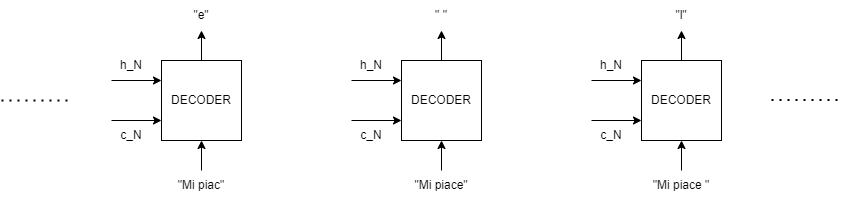

Now lower level point of view. $A^{'}$ denotes the LSTM module of the decoder.

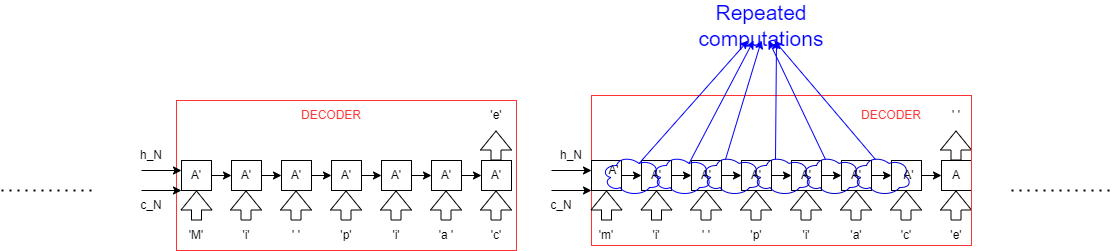

We would like that, for generating the next italian character, we compute only the last output, and not also all the previous outputs. This can be easily done.

For generating the next italian character $X^{'}_{T+1}$, we give to the decoder only the last generated character $X^{'}_{T}$. So, we use only one LSTM decoder module $A^{'}$. 

In addition, instead of setting as initial states of the decoder the encoding coming from the LSTM encoer (i.e. $h_N, C_N$), we set as initial states the states coming from the generation of the last character $X_{T}$, namely $h^{'}_{T}, C^{'}_T$. 

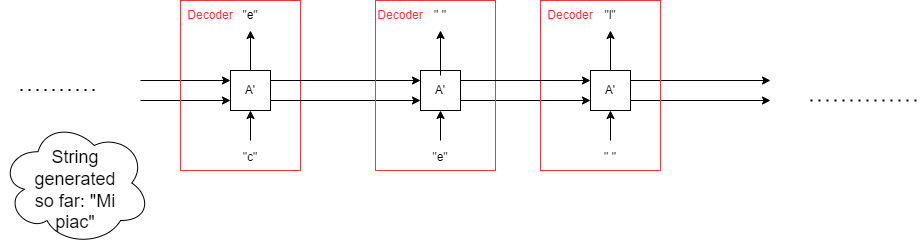 

From an high level point of view: 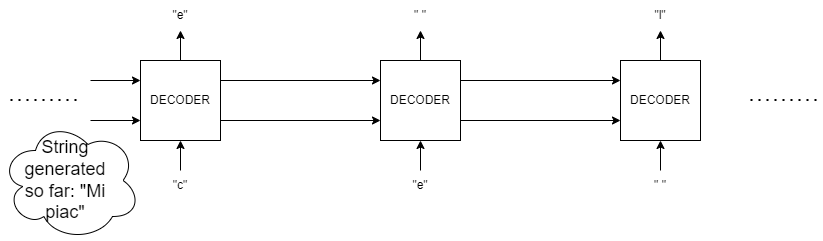

Of course, for generating the very first italian character, we set as initial states of the decoder the encoding from the LSTM encoder, i.e. $h_N, C_N$.

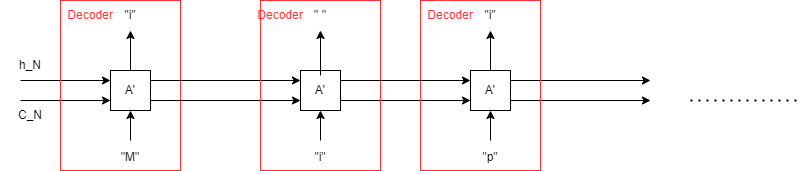

This way of generating italian text is completely equivalent to the previous one. But it is more efficient, since we avoid a lot of repeated computations.

Let's now see how to implement that.

### Different model
First of all, we have to define a different model, specific for that generation approach. It has the same weigths (it is already trained).

**Encoder: it is simply the extraction of the LSTM encoder from our model**

In [50]:
encoder_inputs = model.input[0]
encoder_outputs, last_h, last_c = model.layers[2].output
encoder_states = [last_h, last_c]
encoder_model = Model(encoder_inputs, encoder_states)

**Decoder: it is simply the LSTM decoder + dense layer, with the difference that it takes in input also the first h^{'}_0 and the first C^{'}_0.**

In [51]:
decoder_inputs = model.input[1]
decoder_first_h = Input(shape=(latent_dim,))
decoder_first_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_first_h, decoder_first_c]
decoder_lstm = model.layers[3]
decoder_outputs, last_h, last_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [last_h, last_c]

decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(inputs=[decoder_inputs]+decoder_states_inputs, outputs=[decoder_outputs]+decoder_states)

### Translation

In [66]:
def translate(english_sentence):
  # One-hot encoding of the english sentence
  x = oneHotEncode_english(english_sentence)

  # Encoding computed by the encoder: this is the first states value for the decoder module
  states_value = encoder_model.predict(x)

  # One-hot encoding of the last generated italian char.
  # At the beginning it is the START character '\t'.
  last_char = np.zeros((1,1,m))
  last_char[0, 0, italian_char2index['\t']] = 1.0

  # Generated italian sentence, as a string
  # At the beginning, empty string.
  italian_sentence = ''

  stop_condition = False

  while not stop_condition:
    # Outputs of the decoder model: cat distributions and `last_h`,`last_c`, which are the new states values
    cat_distributions, last_h, last_c = decoder_model([last_char]+states_value)
    # Extract the cat distribution
    cat_distribution = cat_distributions[0, -1, :]

    # New generated italian char
    generated_char_index = np.argmax(cat_distribution)
    generated_char = italian_index2char[generated_char_index]
    italian_sentence += generated_char

    if generated_char=='\n' or len(italian_sentence)>M:
      stop_condition = True

    # Update the last generated char  
    last_char = np.zeros((1, 1, m))
    last_char[0, 0, generated_char_index] = 1.0

    # Update states values
    states_value = [last_h, last_c]

  return italian_sentence

In [67]:
translate('Run!')

'Corri!\n'

In [64]:
translate('Wow!')

'Wow!\n'

In [65]:
translate('Duck!')

'Tuffatevi!\n'